In [1]:
import sys
sys.path.insert(1, '/home/maria/Documents/EnsemblePursuit')
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [2]:
data_path='/home/maria/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
#Uncomment to compute U and V
ep=EnsemblePursuit(n_components=200,lam=0.01,n_kmeans=200)
model=ep.fit(S.T[:10000,:])
V=model.components_
U=model.weights
np.save('U.npy',U)
np.save('V.npy',V)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)
obtained 200 PCs in 25.0135 seconds
initialized 200 clusters with k-means in 41.1623 seconds
ensemble 0, time 26.15, nr neurons 6340, EV 0.0086
ensemble 25, time 149.14, nr neurons 206, EV 0.0329
ensemble 50, time 245.77, nr neurons 90, EV 0.0420
ensemble 75, time 334.75, nr neurons 95, EV 0.0492
ensemble 100, time 417.04, nr neurons 100, EV 0.0551
ensemble 125, time 496.53, nr neurons 80, EV 0.0605
ensemble 150, time 567.66, nr neurons 50, EV 0.0652
ensemble 175, time 633.05, nr neurons 46, EV 0.0695
ensemble 199, time 693.92, nr neurons 41, EV 0.0734
average sparsity is 0.0100


In [3]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

In [6]:
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
Sp = V.T
Sp = zscore(Sp, axis=1)
ly, lx, nstim = mov.shape
#print(nstim)
NT = Sp.shape[1]
NN=Sp.shape[0]
mov=mov[:,:,:NT]
nr_of_components=200

print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ Sp[:,itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, ncomps))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a littleb

proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
beh=motSVD[:,:10000]
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V.T[:,itrain].T))
Vpred = np.matmul(A.T, beh[:,itest])
beh_corr_lst=[]
for j in range(0,nr_of_components):
    beh_corr_lst.append(np.corrcoef(Vpred[j,:],V.T[j,itest])[0,1])

10000


In [9]:
stat = np.load((data_path+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 

In [11]:
Spred = np.reshape(B0, (-1,NN)).T @  X[:,itest]

stim_corr_lst=[]
nr_of_components=200
for j in range(0,nr_of_components):
    stim_corr_lst.append(np.corrcoef(Sp[j,itest],Spred[j,:])[0,1])
#print(corr_lst)

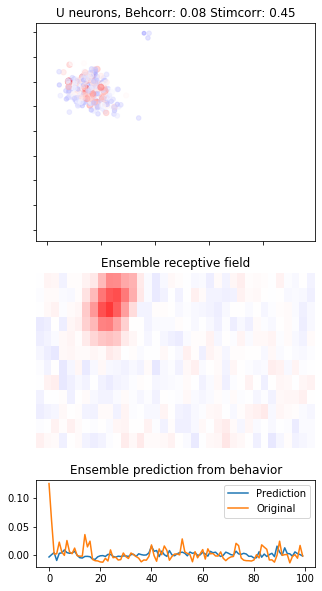

In [69]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(5,10))

gs1 = gridspec.GridSpec(3,1, figure=fig,height_ratios=[5,4,2])
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])

rfmax = np.max(B0)
def U_plot(ax,xpos,ypos,lam,comp,beh_corr,stim_corr):
    ax.scatter(xpos, -ypos, s = 50 * lam, c = comp, cmap='bwr', alpha = .5)
    ax.set_title('U neurons, Behcorr: '+str(beh_corr)[0:4]+' Stimcorr: '+str(stim_corr)[:4])
    #plt.title('Behcorr: '+str(beh_corr)[0:4]+' Stimcorr: '+str(stim_corr)[:4])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
def receptive_field(ax,B0_one):
    ax.set_title('Ensemble receptive field')
    ax.imshow(B0_one, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    #plt.title('PC %d'%(1+j))
    ax.axis('off')
    
def behavior_pred(ax,Vpred,V):
    ax.set_title('Ensemble prediction from behavior')
    ax.plot(Vpred[:100],label='Prediction')
    ax.plot(V[:100],label='Original')
    ax.legend()
    
ind=60

comp= U[:,ind]
comp= comp/np.max(np.abs(comp))
lam = np.abs(comp)


U_plot(ax1,xpos,ypos,lam,comp,beh_corr_lst[ind],stim_corr_lst[ind])
receptive_field(ax2,B0[:,:,ind])
behavior_pred(ax3,Vpred[ind,:],V[:,ind])

indices=[0,1,2,13,15,17,20,37,38,39,40,50,60,100,150,199]

In [18]:
print(Vpred.shape)
print(V.shape)

(200, 2500)
(10000, 200)


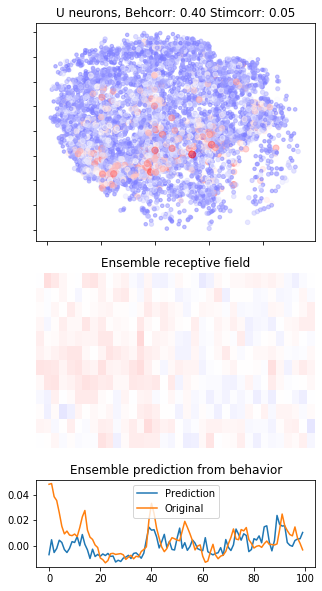

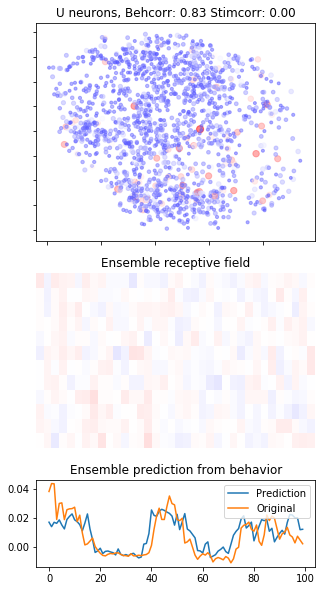

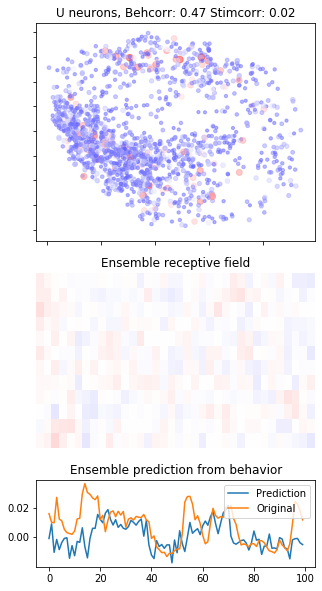

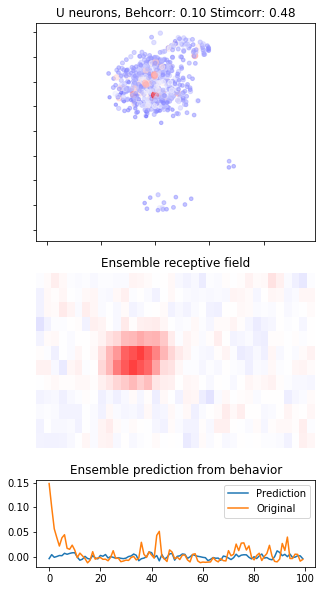

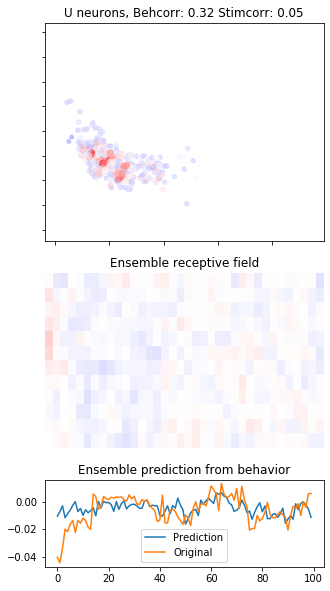

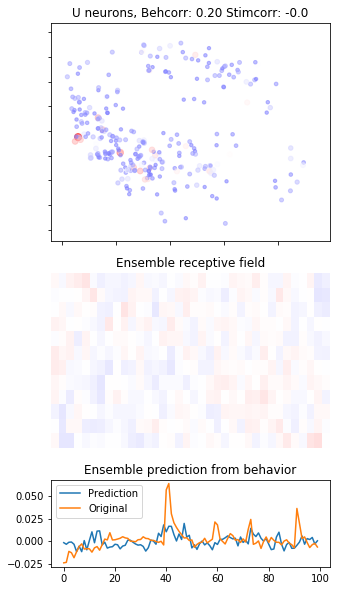

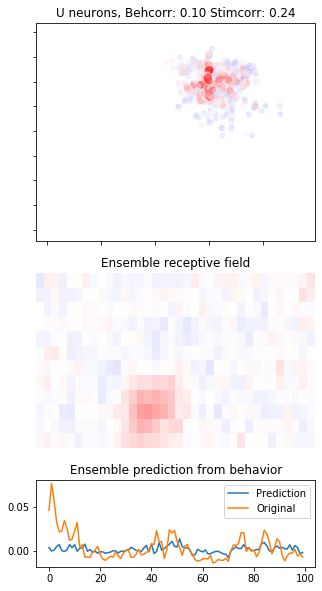

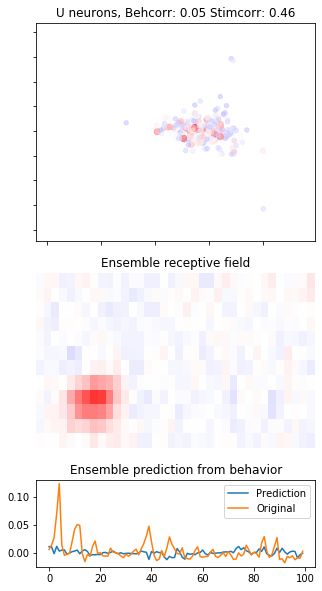

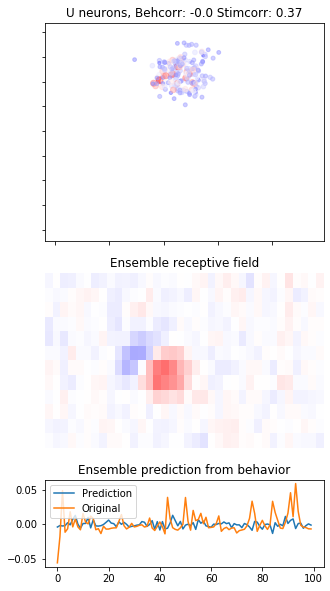

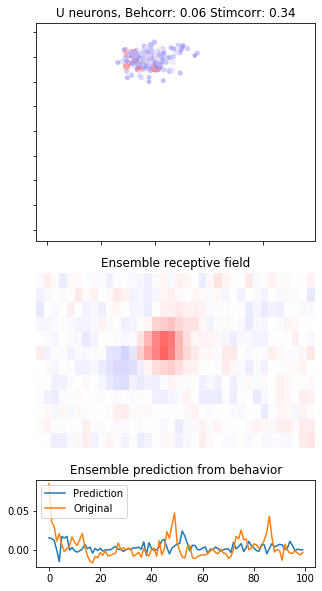

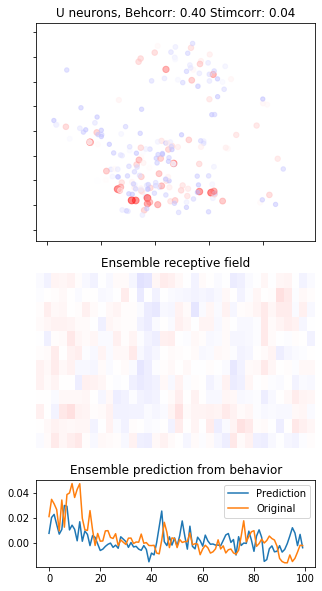

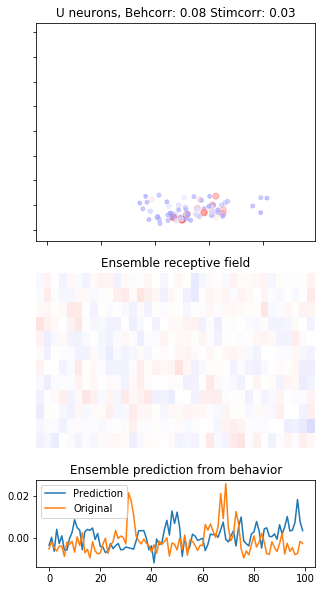

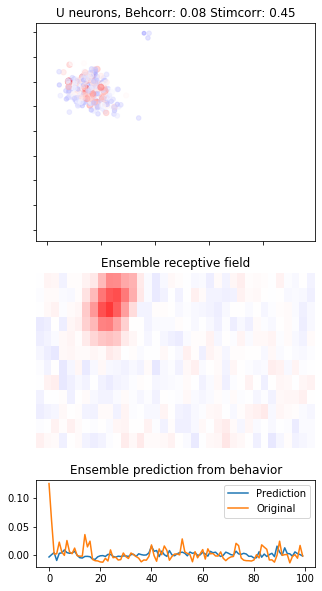

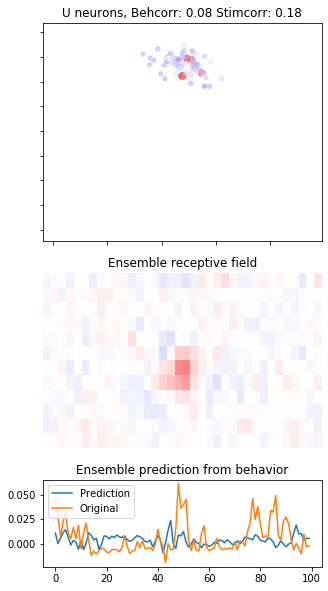

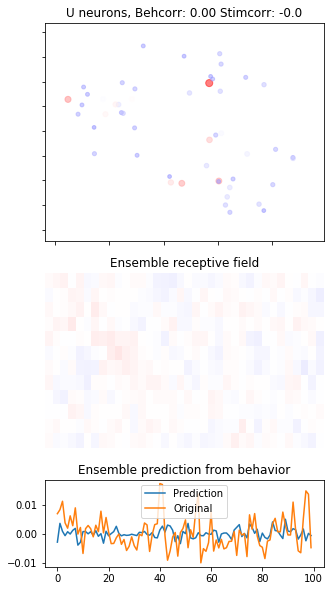

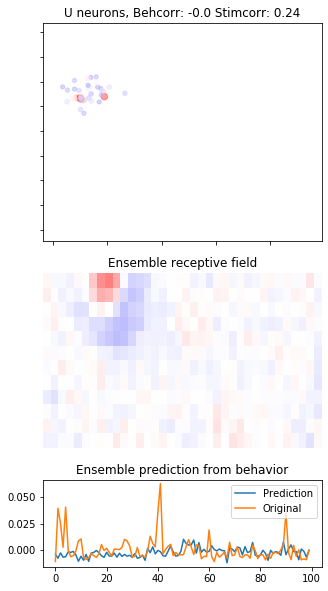

In [70]:
i=0

for ind in indices:
    fig = plt.figure(figsize=(5,10))

    gs1 = gridspec.GridSpec(3,1, figure=fig,height_ratios=[5,4,2])
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])
    ax3 = fig.add_subplot(gs1[2])
    
    comp= U[:,ind]
    comp= comp/np.max(np.abs(comp))
    lam = np.abs(comp)

    rfmax = np.max(B0)
    U_plot(ax1,xpos,ypos,lam,comp,beh_corr_lst[ind],stim_corr_lst[ind])
    receptive_field(ax2,B0[:,:,ind])
    behavior_pred(ax3,Vpred[ind,:],V[:,ind])
    plt.savefig('plot_'+str(i)+'.png')
    i+=1